In [60]:
import time 
import random
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib
import seaborn as sns
import googlemaps
import folium
from folium.plugins import MarkerCluster

from bs4 import BeautifulSoup
import requests
import urllib.request

sns.set()
%matplotlib inline

## Scraping data from https://www.myrent.co.nz/

In [364]:
urls = []
n_pages = 0

for page in range(1,51):

    n_pages += 1
    search_url = 'https://www.myrent.co.nz/rentals/auckland/page/' + str(page)
    response = requests.get(search_url)
    search_soup = BeautifulSoup(response.text, 'html.parser')
    links = [a['href'] for a in search_soup.find_all('a', href = True)]
    listings = set([listing for listing in links if '/listings/' in listing])

    if listings != []:
        for idnum in listings:
            urls.append('https://www.myrent.co.nz' + idnum)

    if urls != []:
        
        streets = []
        areas = []
        cities = []
        prices = []
        beds = []
        baths = []
        
        for url in urls:
            response = requests.get(url)
            listing_soup = BeautifulSoup(response.text, 'html.parser')
            address = listing_soup.find('h4').text
            address = address.split(', ')

            if len(address) > 2:
                street = address[0]
                area = address[1]
                city = address[2]
            elif len(address) == 2:
                street = ''
                area = address[0]
                city = address[1]
            else:
                continue

            street = street.replace('\n', '')
            area = area.replace(' ', '')
            streets.append(street)
            areas.append(area)
            cities.append(city)

            rent_container = listing_soup.find_all('div', class_="listing__header-rent")
            rent = rent_container[0].text
            rent = rent.replace('$', '')
            rent = rent.replace(' per week', '')
            rent = rent.replace(',', '')
            rent = rent.replace('.', '')
            prices.append(float(rent))

            beds_container = listing_soup.find_all('div', class_="listing__summary-count")
            bed = beds_container[0].text
            bath = beds_container[1].text
            beds.append(float(bed))
            baths.append(float(bath))

    else:
        break
        
    time.sleep(random.randint(1,2))

print('You scraped {} pages containing {} properties.'.format(n_pages, len(urls)))

You scraped 50 pages containing 500 properties.


In [365]:
results = pd.DataFrame({
    'Street': streets,
    'Area': areas,
    'City': cities,
    'Price': prices,
    'beds': beds,
    'baths': baths,
    'Url' : urls
})

try:
    results['Rent_per_room'] = results.Price / results.beds
except:
    results['Rent_per_room'] = results.Price

In [366]:
results.head()

,Street,Area,City,Price,beds,baths,Url,Rent_per_room
0,16 Clark Street,Manurewa,Auckland,625.0,3.0,1.0,https://www.myrent.co.nz/listings/M9RFMD,208.333333
1,697 Mount Albert Road,RoyalOak,Auckland,760.0,4.0,1.0,https://www.myrent.co.nz/listings/FYM1H1,190.000000
2,116 Arney Road,Remuera,Auckland,2000.0,4.0,3.0,https://www.myrent.co.nz/listings/WXJSVP,500.000000
3,2B/15 Nelson Street,AucklandCentral,Auckland,360.0,1.0,1.0,https://www.myrent.co.nz/listings/DK8QVH,360.000000
4,102/46 Rosedale Road,Rosedale,Auckland,635.0,2.0,2.0,https://www.myrent.co.nz/listings/S6XZKD,317.500000


In [11]:
results['avg_per_area'] = results['Rent_per_room'].groupby(results['Area']).transform('mean')

## Exploratory Data Analysis

In [367]:
print('There are {} areas in Auckland with listings currently available.'.format(len(set(areas))))

There are 136 areas in Auckland with listings currently available.


In [368]:
results.Area.value_counts()

AucklandCentral      47
MountEden            24
Papatoetoe           14
Massey               12
NewLynn              11
MountWellington      11
Henderson            11
GreyLynn             10
Remuera              10
FlatBush              9
Parnell               8
Epsom                 8
Grafton               8
Sandringham           7
Ellerslie             7
Otahuhu               7
Avondale              7
Torbay                7
Manurewa              7
Takapuna              7
Howick                6
MountRoskill          6
PakurangaHeights      6
EdenTerrace           6
BotanyDowns           5
Ranui                 5
SaintJohns            5
BrownsBay             5
Lynfield              5
TeAtatuSouth          5
                     ..
HuntingtonPark        1
StanmoreBay           1
Glendene              1
EastTamakiHeights     1
Waiuku                1
HeraldIsland          1
Sunnyvale             1
Panmure               1
Matakana              1
AlbanyHeights         1
Redvale         

In [369]:
mean_per_area = results.groupby('Area').mean()

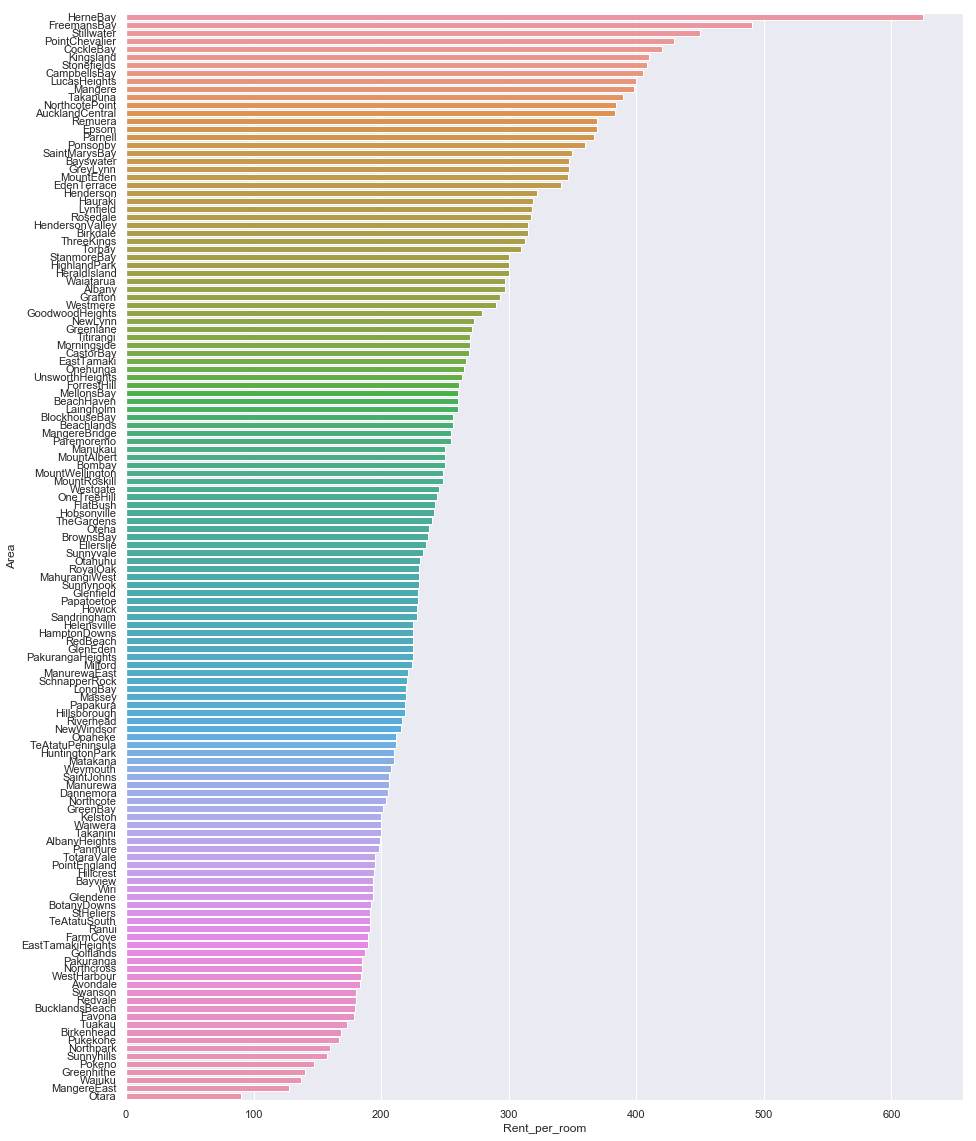

In [373]:
mean_per_area.sort_values(by='Rent_per_room', ascending=False, inplace=True)
fig = plt.figure(figsize=(15,20))
sns.barplot(mean_per_area.Rent_per_room, mean_per_area.index)

## Plotting listings on Google Maps

In [374]:
gmaps = googlemaps.Client(key='api-key-here')

In [375]:
lat = []
lng = []
for index, row in results.iterrows():
    if row.Street != '':
        geocode_result = gmaps.geocode(row.Street + row.Area + ', Auckland')
    else:
        geocode_result = gmaps.geocode(row.Area + ', Auckland')
    
    lat.append(geocode_result[0]['geometry']['location']['lat'])
    lng.append(geocode_result[0]['geometry']['location']['lng'])
    
    if index%300 == 0:
        print('Got {} coordinates!'.format(index))

Got 0 coordinates!
Got 300 coordinates!


In [376]:
results['lat'] = lat
results['lng'] = lng

In [119]:
results.head(5)

,Street,Area,City,Price,beds,baths,Url,Rent_per_room,lat,lng,avg_per_area
0,16 Clark Street,Manurewa,Auckland,625.0,3.0,1.0,https://www.myrent.co.nz/listings/M9RFMD,208.333333,-37.014003100000004,174.8874217,206.428571
1,697 Mount Albert Road,RoyalOak,Auckland,760.0,4.0,1.0,https://www.myrent.co.nz/listings/FYM1H1,190.000000,-36.9116852,174.77323280000002,230.000000
2,116 Arney Road,Remuera,Auckland,2000.0,4.0,3.0,https://www.myrent.co.nz/listings/WXJSVP,500.000000,-36.8666024,174.7909905,369.000000
3,2B/15 Nelson Street,AucklandCentral,Auckland,360.0,1.0,1.0,https://www.myrent.co.nz/listings/DK8QVH,360.000000,-36.8466718,174.75996809999998,383.546099
4,102/46 Rosedale Road,Rosedale,Auckland,635.0,2.0,2.0,https://www.myrent.co.nz/listings/S6XZKD,317.500000,-36.736024,174.72967419999998,317.500000


In [169]:
results['rent_decile'] = pd.qcut(results['Rent_per_room'], 10, labels=False)

colours_list = ['#E3020F','#C90424','#B0073A','#970A4F','#7E0D65',
                '#640F7A','#4B1290','#3215A5','#1918BB','#001BD1']

In [192]:
results['popup'] = '<a href="'+results['Url']+'">Original Listing</a>'

In [337]:
auckland_map = folium.Map(location=[-36.854217,174.759058], tiles='CartoDB dark_matter', zoom_start = 12)

locations = results[['lat', 'lng']]
locationlist = locations.values.tolist()

for point in range(0, len(locationlist)):
    folium.CircleMarker(locationlist[point], 
                        radius=8,
                        color=colours_list[results['rent_decile'][point]],
                        fill=True,
                        fill_color=colours_list[results['rent_decile'][point]],
                        fill_opacity=0.2,
                        popup=(
                            str(results['popup'][point]) + '</br>' + '</br>'
                            "<pre>Rent per room: ${rent}</br>" +
                            "Weekly Total rent: ${total}</br>" +
                            "Average rent per room in area: ${area_avg}</br>" +
                            "Beds: {beds}</br>" + 
                            "Baths: {baths}</br>" + 
                            "Area: {area}</pre></br>"
                        ).format(rent=str(int(results['Rent_per_room'][point])),
                                 total=str(int(results['Price'][point])),
                                 area_avg=str(int(results['avg_per_area'][point])),
                                 beds=str(int(results['beds'][point])),
                                 baths=str(int(results['baths'][point])),
                                 area=str(results['Area'][point])
                       )).add_to(auckland_map)

In [338]:
auckland_map

In [339]:
auckland_map.save('auckland_housing_map.html')